In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns

### For loading data if you change the dirrectory you can access to normalized data using different method for each device.

In [2]:
num_files = 19
dfs={}

for i in range(1, num_files + 1):
    filename = f'data/normal_moving_ten/normalized_device{i}.csv' #filename = f'data/device{i}.csv' filename = f'data/normal_moving_ten/device{i}.csv' OR filename = f'data/normal_moving_thirty/device{i}.csv' OR filename = f'data/normal_relative_change/device{i}.csv' 
    dfs[i] = pd.read_csv(filename)

In [6]:
dfs[15].head()

,timestamp_device,device_id,p_avg,p_min,p_max,y,mov_ten_avg,mov_ten_min,mov_ten_max
0,2021-10-24 08:11:00+00:00,dev-5t2uzv34fzcn,1407.977520,1350.20745,1471.12155,0.0,1407.977520,1350.20745,1471.12155
1,2021-10-24 08:12:00+00:00,dev-5t2uzv34fzcn,1408.985138,1370.35980,1471.12155,0.0,1408.985138,1370.35980,1471.12155
2,2021-10-24 08:13:00+00:00,dev-5t2uzv34fzcn,1403.947050,1350.20745,1450.96920,0.0,1403.947050,1350.20745,1450.96920
3,2021-10-24 08:14:00+00:00,dev-5t2uzv34fzcn,1406.907282,1370.35980,1450.96920,0.0,1406.907282,1370.35980,1450.96920
4,2021-10-24 08:15:00+00:00,dev-5t2uzv34fzcn,1409.321010,1370.35980,1450.96920,0.0,1409.321010,1370.35980,1450.96920


#### Chunking the data and return columns needed for One dimensional clustering

In [7]:
def get_chunk(df,chunk_size):
    chunks = []
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        chunks.append(chunk[['mov_ten_avg']])
    chunks = chunks[:-1] #Remove the last chunk if it is incomplete
    return chunks

In [9]:
def flatten_chunks(chunks, col_names):
    return np.array([np.stack([chunk[col].to_numpy() for col in col_names], axis=-1) for chunk in chunks])

In [12]:
def apply_clustering(flat_chunks_array, n_clusters, metric):
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, n_init=1, random_state=42, metric=metric)
    y_pred = ts_kmeans.fit_predict(flat_chunks_array)
    centroids = ts_kmeans.cluster_centers_
    return y_pred, centroids

In [16]:
def assign_chunk_labels(chunks, y_pred):
    y_pred_full = np.concatenate([np.full(len(chunk), cluster) for chunk, cluster in zip(chunks, y_pred)])
    return y_pred_full

In [10]:
def create_final_dataframe(flat_chunks_array, y_pred, col_names):
    num_samples, chunk_size, num_features = flat_chunks_array.shape
    reshaped_data = flat_chunks_array.reshape(-1, num_features)
    final_df_data = {col: reshaped_data[:, i] for i, col in enumerate(col_names)}
    final_df_data["y_pred"] = np.repeat(y_pred, chunk_size)
    final = pd.DataFrame(final_df_data)
    
    pd.set_option('display.float_format', lambda x: '%.10f' % x)
    return final

In [11]:
def plot_kde_by_y_pred(df, col_names, device_id):
    plt.figure(figsize=(10, 6))
    on_color = sns.color_palette("Blues", n_colors=len(col_names))
    off_color = sns.color_palette("Reds", n_colors=len(col_names))
    for col_idx, col in enumerate(col_names):
        sns.kdeplot(df.loc[df['y_pred'] == 1, col], color=on_color[col_idx], fill=True, label=f'{col} | y_pred = 1 | Device {device_id}')
        sns.kdeplot(df.loc[df['y_pred'] == 0, col], color=off_color[col_idx], fill=True, label=f'{col} | y_pred = 0 | Device {device_id}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'KDE Plots by y_pred for Device {device_id}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'KDE_for_device{device_id}.png')
    plt.show()

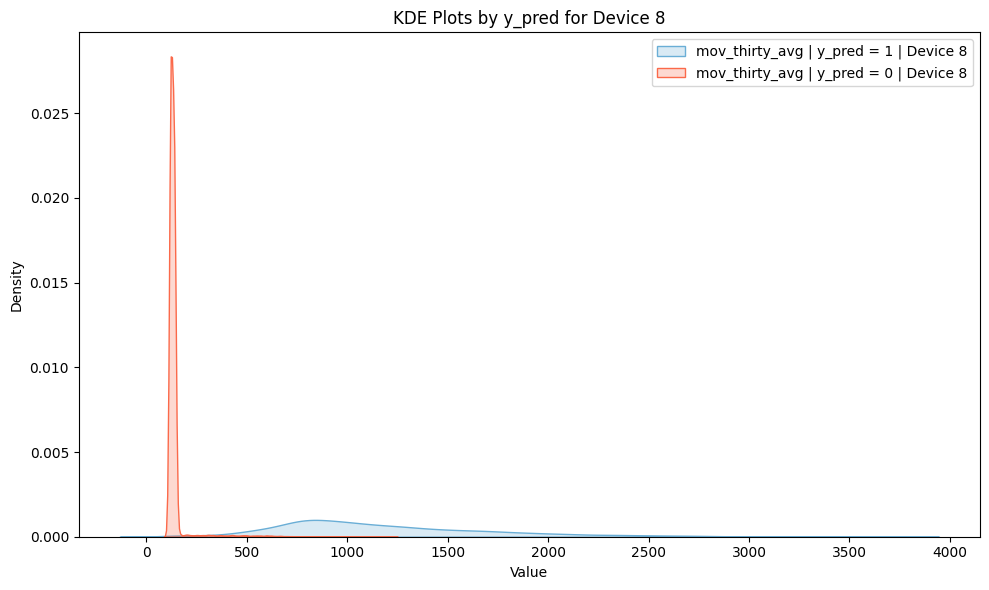

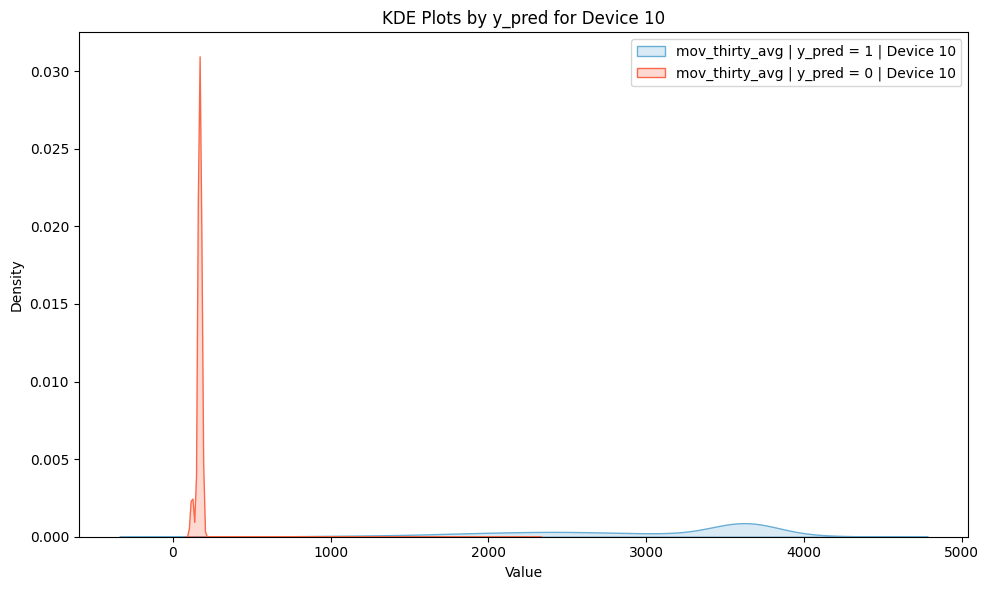

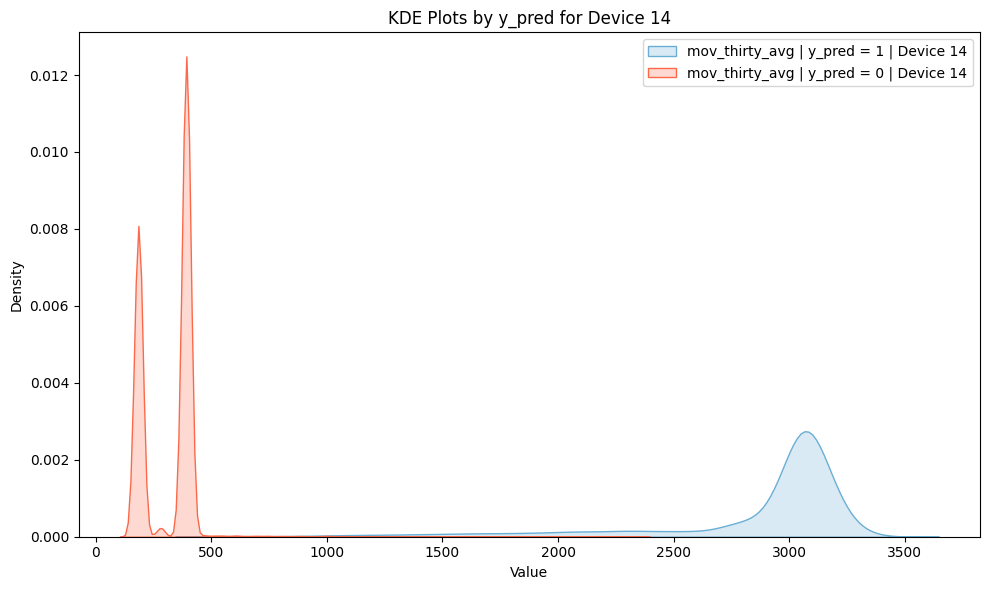

Device 8 centroids:
[[[ 211.11118571]
  [ 135.06632535]
  [ 133.32954702]
  [ 133.24926852]
  [ 132.08156589]
  [ 133.43694707]
  [ 133.43187571]
  [ 133.41966182]
  [ 133.41450226]
  [ 133.41088788]
  [ 133.40559128]
  [ 133.42102262]
  [ 133.41285088]
  [ 133.4115579 ]
  [ 132.71650679]
  [ 133.31685342]
  [ 133.41025256]
  [ 135.11914078]
  [ 203.03405056]
  [ 145.6133329 ]]

 [[ 845.02729566]
  [1273.00421182]
  [1685.46212429]
  [1288.5885059 ]
  [1234.00047734]
  [1233.16381906]
  [1232.73014933]
  [1232.30754724]
  [1232.0911706 ]
  [1231.61953989]
  [1219.3651643 ]
  [1231.98507228]
  [1232.17004872]
  [1232.49554951]
  [1232.63641818]
  [1233.7847965 ]
  [1318.74054158]
  [1740.74520681]
  [1249.25902136]
  [ 822.20235611]]]
Device 10 centroids:
[[[ 208.24104621]
  [ 171.83158922]
  [ 167.87054978]
  [ 170.69674771]
  [ 170.66896431]
  [ 170.63654153]
  [ 170.66666375]
  [ 170.68118817]
  [ 170.69068684]
  [ 170.66989308]
  [ 170.65296338]
  [ 170.66513264]
  [ 170.67216567]
 

In [12]:
# Processing loop for all devices
all_final_dfs = []
columns = ['mov_thirty_avg']
chunk_size = 20
n_clusters = 2
metric = "dtw"
centroids_dict = {}
device_ids = [8, 10, 14]


for device_id in device_ids:
    chunked = get_chunk(dfs[device_id], chunk_size)
    flattened = flatten_chunks(chunked, columns)
    y_pred, centroids = apply_clustering(flattened, n_clusters, metric)
    final_df = create_final_dataframe(flattened, y_pred, columns)
    all_final_dfs.append(final_df)
    
    # Store centroids
    centroids_dict[device_id] = centroids
    
    # Plot for each device
    plot_kde_by_y_pred(final_df, columns, device_id)


In [13]:
# Print centroids for each device
for device_id, centroids in centroids_dict.items():
    print(f"Device {device_id} centroids:")
    for cluster_id, centroid in enumerate(centroids):
        print(f"  Cluster {cluster_id} centroid: {centroid}")

Device 8 centroids:
  Cluster 0 centroid: [[211.11118571]
 [135.06632535]
 [133.32954702]
 [133.24926852]
 [132.08156589]
 [133.43694707]
 [133.43187571]
 [133.41966182]
 [133.41450226]
 [133.41088788]
 [133.40559128]
 [133.42102262]
 [133.41285088]
 [133.4115579 ]
 [132.71650679]
 [133.31685342]
 [133.41025256]
 [135.11914078]
 [203.03405056]
 [145.6133329 ]]
  Cluster 1 centroid: [[ 845.02729566]
 [1273.00421182]
 [1685.46212429]
 [1288.5885059 ]
 [1234.00047734]
 [1233.16381906]
 [1232.73014933]
 [1232.30754724]
 [1232.0911706 ]
 [1231.61953989]
 [1219.3651643 ]
 [1231.98507228]
 [1232.17004872]
 [1232.49554951]
 [1232.63641818]
 [1233.7847965 ]
 [1318.74054158]
 [1740.74520681]
 [1249.25902136]
 [ 822.20235611]]
Device 10 centroids:
  Cluster 0 centroid: [[208.24104621]
 [171.83158922]
 [167.87054978]
 [170.69674771]
 [170.66896431]
 [170.63654153]
 [170.66666375]
 [170.68118817]
 [170.69068684]
 [170.66989308]
 [170.65296338]
 [170.66513264]
 [170.67216567]
 [170.68440191]
 [170.6

,timestamp_device,device_id,p_avg,p_min,p_max,y,mov_thirty_avg,mov_thirty_min,mov_thirty_max
0,2021-10-24 08:11:00+00:00,dev-5t2uzv34fzcn,1407.9775200000,1350.2074500000,1471.1215500000,0.0000000000,1407.9775200000,1350.2074500000,1471.1215500000
1,2021-10-24 08:12:00+00:00,dev-5t2uzv34fzcn,1408.9851375000,1370.3598000000,1471.1215500000,0.0000000000,1408.9851375000,1370.3598000000,1471.1215500000
2,2021-10-24 08:13:00+00:00,dev-5t2uzv34fzcn,1403.9470500000,1350.2074500000,1450.9692000000,0.0000000000,1403.9470500000,1350.2074500000,1450.9692000000
3,2021-10-24 08:14:00+00:00,dev-5t2uzv34fzcn,1406.9072822034,1370.3598000000,1450.9692000000,0.0000000000,1406.9072822034,1370.3598000000,1450.9692000000
4,2021-10-24 08:15:00+00:00,dev-5t2uzv34fzcn,1409.3210100000,1370.3598000000,1450.9692000000,0.0000000000,1409.3210100000,1370.3598000000,1450.9692000000


### For Multi-Dimensional clustering only get_chunk will change:

In [ ]:
new_columns = ['moving_avg_one','moving_min_one','moving_max_one']

In [ ]:
def get_chunk(df,chunk_size):
    chunks = []
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        chunks.append(chunk[['timestamp_device', 'p_avg', 'y', 'p_min', 'p_max', 
                                                         'moving_avg_one', 'moving_min_one', 'moving_max_one', 
                                                         'moving_avg_two', 'moving_min_two', 'moving_max_two', 
                                                         'z_score_avg', 'z_score_min', 'z_score_max', 
                                                         'p_avg_rel_change', 'p_min_rel_change', 'p_max_rel_change']])
    chunks = chunks[:-1] #Remove the last chunk if it is incomplete
    return chunks